# Exploring .icmh5 File Structure

### Useful Imports and Preliminaries

In [1]:
import os
import sys
sys.path.append("..")  # add project root

import h5py

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from tqdm import tqdm

from src.data_utils import *

# pending useful sklearn imports

In [2]:
pd.options.display.float_format = '{:10,.2f}'.format

In [3]:
np.random.seed(420)

In [4]:
sns.set_theme(context="talk")

In [5]:
# path constants
data_dir = "/home/mr2238/project_pi_np442/mr2238/accelerate/data"
img_dir = "/home/mr2238/project_pi_np442/mr2238/accelerate/imgs/overview"
labels_path = os.path.join(data_dir, "labels")
raw_data_path = os.path.join(data_dir, "raw_data")

In [6]:
# list files
h5py_files = [f for f in os.listdir(raw_data_path) if f.endswith(".icmh5")]
print(f"Number of h5py files: {len(h5py_files)}")
print(f"Example file: {h5py_files[0]}")

Number of h5py files: 215
Example file: 1002.icmh5


### Summarize a random file

Here we explore the structure and data series that compose one recording.

In [20]:
# load single random example
idx = np.random.randint(0, len(h5py_files))
example_file = h5py_files[idx]

In [21]:
print(example_file)

1659.icmh5


In [22]:
# extract invalid value and numerics/waveforms
with h5py.File(os.path.join(raw_data_path, example_file), "r") as f:
    invalid_value = float(f.attrs["invalidValue"][0])
    print(f"Invalid value: {invalid_value}")
    numerics = list(f["numerics"].keys())
    waves = list(f["waves"].keys())
    print(f"Numerics: {numerics}")
    print(f"Waves: {waves}")


Invalid value: -99999.0
Numerics: ['hr', 'rr', 'rso2l', 'rso2r', 'spo2', 't']
Waves: ['abp', 'art', 'cvp', 'deoxhg_l', 'deoxhg_r', 'ecg.ii', 'icp', 'oxhg_l', 'oxhg_r', 'pleth', 'scthg_l', 'scthg_r', 'sthg_index_l', 'sthg_index_r']


In [23]:
# summarize random example file
print(f"Summarizing example file {example_file}:")
h5py_summarize(os.path.join(raw_data_path, example_file))


Summarizing example file 1659.icmh5:
Summarizing file /home/mr2238/project_pi_np442/mr2238/accelerate/data/raw_data/1659.icmh5:
Global attributes:
dataCollectionSoftware: ['']
dataEndTime: ['2021/04/09 10:52:04']
dataEndTimeUnix: ['1617965524']
dataProcessingSoftware: ['ICM+ 9.3.1.1']
dataStartTime: ['2021/04/08 16:54:27']
dataStartTimeUnix: ['1617900867']
dateTimeFormat: ['yyyy/mm/dd hh:nn:ss']
duration: ['64657 seconds']
formatVersion: ['1.3']
invalidValue: ['-99999']
protocol: ['Generic']

Contents:
Group: aux
Group: aux/ICM+
Dataset: aux/ICM+/DTAFilesLog, shape: (42,), dtype: object
Group: definitions
Dataset: definitions/indexStruct, shape: (4,), dtype: [('field', 'O'), ('description', 'O')]
Attributes:
CLASS: b'TABLE'
FIELD_0_NAME: b'field'
FIELD_1_NAME: b'description'
TITLE: b'indexStruct'
VERSION: b'3.0'
description: ["Description of the 'index' dataset/attribute format"]
Dataset: definitions/qualityRef, shape: (25,), dtype: [('indicator', '<u4'), ('description', 'O')]
Attribut

In [ ]:
with h5py.File(os.path.join(raw_data_path, example_file), "r") as f:
    print(pd.DataFrame(f["definitions/qualityRef"][:]))

Now here we summarize the various data series to observe units and distributions:

In [ ]:
# summarize numerics and waveforms
def summarize_series(name, obj, invalid_value=invalid_value):
    print(f"Dataset: {name}")
    df = pd.DataFrame(obj[:])
    df.replace(invalid_value, np.nan, inplace=True)
    print(f"Number of missing values: {df.isna().sum().sum()}")
    print(df.describe())
    print("\n")
    return

print(f"Summarizing statistics for numerics and waveforms in file {example_file}:")
with h5py.File(os.path.join(raw_data_path, example_file), "r") as f:
    f["numerics"].visititems(summarize_series)
    f["waves"].visititems(summarize_series)

### Plot a random file

Here we plot the various data series of a random file to observe their dynamics. 

#### Timeseries data

First we can just naively plot a data series without considering data gaps.

In [ ]:
with h5py.File(os.path.join(raw_data_path, example_file), "r") as f:
    df = pd.DataFrame(f["numerics/hr"])
    df.replace(invalid_value, np.nan, inplace=True)

fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(df.index/(60*60), df[0], label = "Heart Rate", s=0.5)
ax.set_xlabel("Time (hr)")
ax.set_ylabel("Heart Rate (bpm)")
ax.set_title("Heart Rate over Time")
ax.set_ylim(25, 200)
img_name = f"hr_series_{example_file.removesuffix('.icmh5')}_nogaps.png"
plt.savefig(os.path.join(img_dir, img_name), bbox_inches='tight')
plt.show()
plt.close()

However, there are gaps in this data, as seen in the ``index`` attribute of the file.

In [ ]:
# Plot continuous time series with gaps as NaNs
with h5py.File(os.path.join(raw_data_path, example_file), "r") as f:
    df = build_continuous_time(f, 'numerics/hr')


fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(df.index/(60*60), df[0], label = "Heart Rate", s=0.5)
ax.set_xlabel("Time (hr)")
ax.set_ylabel("Heart Rate (bpm)")
ax.set_title("Heart Rate over Time with recording gaps")
ax.set_ylim(25, 200)

img_name = f"hr_series_{example_file.removesuffix('.icmh5')}_full.png"
fig.savefig(os.path.join(img_dir, img_name), bbox_inches='tight')
fig.show()
# plt.close()

#### Distribution of recording variables

Next we can investigate the general distribution of all the variables of a random recording.

In [ ]:
# can do histograms for all numerics
with h5py.File(os.path.join(raw_data_path, example_file), "r") as f:
    grp = f["numerics"]
    nrows = len(numerics)//2 + 1*(len(numerics)%2)
    fig, axs = plt.subplots(nrows = 2, ncols = nrows, layout='constrained', figsize=(5* (len(numerics)//2 + 1), 8))
    for i, n in enumerate(numerics):
        df = pd.DataFrame(grp[n])
        df.replace(invalid_value, np.nan, inplace=True)
        ax = axs[i%2, i//2]
        if n == "t":
            ax.hist(df[0], bins="auto", density=True, label="Distribution")
        else:
            sns.kdeplot(df[0], ax=ax, fill=True, bw_adjust=3, label="Distribution")
        if n == "spo2":
            ax.set_xlim(70, 110)
        ax.set_ylabel("Density")
        ax.set_xlabel("Value")
        ax.set_title(n + f" Distribution (Invalid Values = {df[0].isna().sum()/ len(df)*100:.3f}%)")
        mean_value = df[0].mean()
        ax.axvline(x=mean_value, color='red', linestyle='--', label=f'Mean: {mean_value:.2f}')
        ax.legend()
    
fig.suptitle(f"Histogram of numeric values for file {example_file}")
img_name = f"numerics_hist_{example_file.removesuffix('.icmh5')}.png"
plt.savefig(os.path.join(img_dir, img_name))
plt.show()
plt.close()

In [ ]:
print(waves)
waves.remove("ecg.ii") # it does not make sense to plot distribution of ECG voltages

In [ ]:
# can do histograms for all waves
with h5py.File(os.path.join(raw_data_path, example_file), "r") as f:
    grp = f["waves"]
    nrows = 4
    ncols = len(waves)//nrows + 1*(len(waves)%nrows)
    fig, axs = plt.subplots(nrows = nrows, ncols = ncols, layout='constrained', figsize=(8*ncols, 4*nrows))
    for i, n in tqdm(enumerate(waves)):
        df = pd.DataFrame(grp[n])
        df.replace(invalid_value, np.nan, inplace=True)
        ax = axs[i%nrows, i//nrows]
        if n == "cvp" or n == "pleth" or n == "icp":
            ax.hist(df[0], bins="auto", density=True, label="Distribution")
        else:
            sns.kdeplot(df[0], ax=ax, fill=True, bw_adjust=3, label="Distribution")
        if n == "spo2":
            ax.set_xlim(70, 110)
        ax.set_ylabel("Density")
        ax.set_xlabel("Value")
        ax.set_title(n + f" Distribution (Invalid Values = {df[0].isna().sum()/ len(df)*100:.3f}%)")
        mean_value = df[0].mean()
        ax.axvline(x=mean_value, color='red', linestyle='--', label=f'Mean: {mean_value:.2f}')
        ax.legend()

for i, a in enumerate(axs.flat):
    if i > len(waves) - 1:
        a.set_axis_off()

fig.suptitle(f"Histogram of waves values for file {example_file}")
img_name = f"waves_hist_{example_file.removesuffix('.icmh5')}.png"
plt.savefig(os.path.join(img_dir, img_name))
plt.show()
plt.close()

### Database-Wide Statistics

In this section, we plot some database-wide statistics to obtain summaries of the whole dataset.

In [ ]:
# loop through all the files and extract duration in seconds with gaps
durations_gaps = {}

for i, file in tqdm(enumerate(h5py_files)):
    key = [s.split(".") for s in file.split("_")][0][0]

    with h5py.File(os.path.join(raw_data_path, file), "r") as f:
        # duration with gaps
        time = int(f.attrs["duration"][0].replace(" seconds", ""))
        durations_gaps[key] = time + durations_gaps.get(key, 0)

In [ ]:
# loop through all the files and extract duration in seconds without gaps
durations_no_gaps = {}

for i, file in tqdm(enumerate(h5py_files)):
    key = [s.split(".") for s in file.split("_")][0][0]

    with h5py.File(os.path.join(raw_data_path, file), "r") as f:
        # duration without gaps
        try:
            index = pd.DataFrame(f["numerics/hr"].attrs["index"])
            time_per_segment = (index["length"]).astype('float64')/index["frequency"]
            time = time_per_segment.sum().item()
            durations_no_gaps[key] = time + durations_no_gaps.get(key, 0)
        except:
            print(f"numerics/hr not found in {file}")

In [ ]:
# plot violin plots of durations with and without gaps

df1 = pd.DataFrame({'Value': np.array(list(durations_no_gaps.values()))/(60*60), 'Group': 'Excluding Gaps'})
df2 = pd.DataFrame({'Value': np.array(list(durations_gaps.values()))/(60*60), 'Group': 'Including Gaps'})

# Concatenate the two DataFrames
combined_df = pd.concat([df1, df2])
medians = combined_df.groupby(['Group'])['Value'].median()

with plt.rc_context({'ytick.left': True}) and sns.axes_style("darkgrid"):
        fig, ax = plt.subplots(figsize=(12,6))
        sns.violinplot(x='Group', y='Value', data=combined_df, ax=ax, hue="Group", palette="pastel")
        ax.set_title('Side-by-Side Boxplots of Dataset Durations')
        ax.set_ylabel('Duration (hours)')
        ax.set_xlabel('')
        ax.set_yticks(np.arange(0, 251, 25), minor=True)
        ax.set_ylim(0, 250)

        for i, v in enumerate(medians):
                ax.text((i+0.025), (v-2), str(round(v, 2)), fontsize = 12)

        img_name = f"duration_distributions.png"
        plt.savefig(os.path.join(img_dir, img_name), bbox_inches='tight')
        plt.show()

### Labels

Now, let us explore the label dataset.

In [7]:
# find all patient ids for whom I have labels
# ptid_list = set()
# for i, file in enumerate(h5py_files):
#     ptid = [s.split(".") for s in file.split("_")][0][0]
#     ptid_list.add(ptid)

# ptid_list = list(ptid_list)
ptid_list = list({fpath.split("_")[0]: fpath for fpath in os.listdir(labels_path) if ".csv" in fpath}.keys())

In [8]:
# random label file
r_id = ptid_list[np.random.randint(0, len(ptid_list))]
df = load_label(r_id, labels_path=labels_path, time="seconds")
df.head()

,DateTime,ABP[mmHg],sABP[mmHg],dABP[mmHg],rSO2L,rSO2R,ABP5min[mmHg],ABP5med[mmHg],affected_rSO2,unaffected_rSO2,...,ULA_Yale_L,MAPopt_Yale_affected_beta,LLA_Yale_affected_beta,ULA_Yale_affected_beta,MAPopt_Yale_L_beta,LLA_Yale_L_beta,ULA_Yale_L_beta,MAPopt_Yale_R_beta,LLA_Yale_R_beta,ULA_Yale_R_beta
0,1548670800000000,113.50,164.30,87.92,71.48,72.01,113.50,113.50,71.48,72.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1548670860000000,113.80,164.10,88.30,71.39,71.96,113.70,113.80,71.39,71.96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1548670920000000,113.10,163.40,87.58,71.79,71.89,113.50,113.70,71.79,71.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1548670980000000,114.30,164.20,88.82,72.00,71.95,113.70,113.80,72.00,71.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1548671040000000,114.20,164.30,88.71,72.31,72.15,113.80,113.80,72.31,72.15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# load df, find seconds elapsed to calculate opt MAP
calc = ["MAPopt_Yale_affected_beta", "LLA_Yale_affected_beta", "ULA_Yale_affected_beta"]
elapsed_times = pd.Series([find_time_elapsed(pt, calc, labels_path) for pt in tqdm(ptid_list)]).dropna()
print(elapsed_times.describe())


 22%|██▏       | 46/206 [00:00<00:00, 226.97it/s]

No time found for 1069
No time found for 1100
No time found for 1141
No time found for 1145
No time found for 1456


 44%|████▍     | 91/206 [00:00<00:00, 212.17it/s]

No time found for 1594
No time found for 1759
No time found for 1769
No time found for 1960


 55%|█████▍    | 113/206 [00:00<00:00, 183.27it/s]

No time found for 2095
No time found for 2117


100%|██████████| 206/206 [00:01<00:00, 170.73it/s]

No time found for 724
count       194.00
mean     10,144.95
std      24,028.14
min       2,940.00
25%       3,780.00
50%       6,930.00
75%      11,385.00
max     332,400.00
dtype: float64


In [17]:
with_data = elapsed_times.shape[0]
all_pt = len(ptid_list)

In [18]:
print(elapsed_times.shape)

(194,)


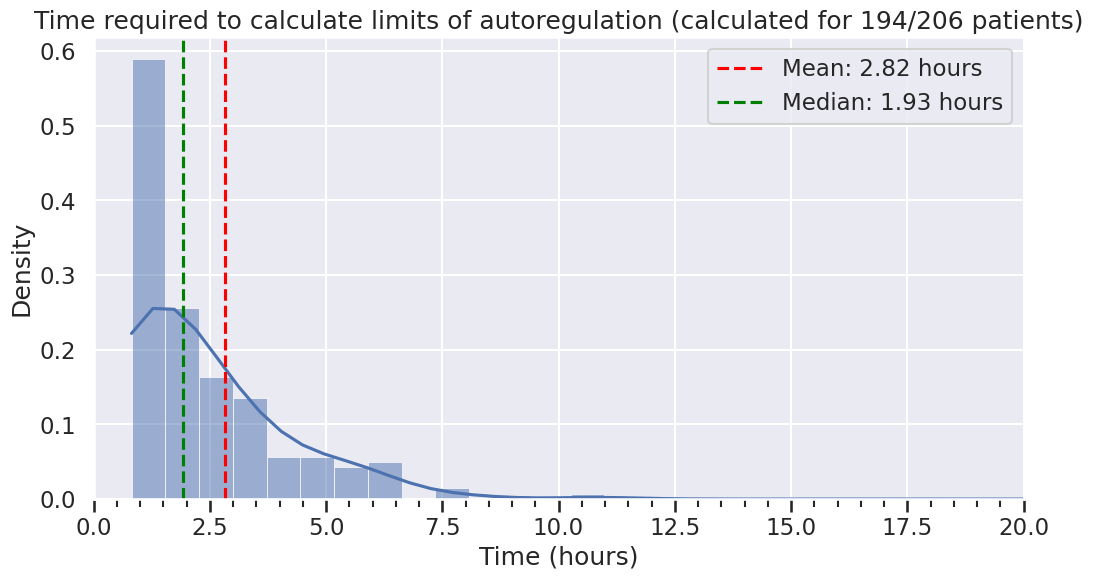

In [19]:
with plt.rc_context({'xtick.bottom': True}):
    fig, ax = plt.subplots(figsize=(12,6))
    sns.histplot(data=pd.Series(elapsed_times)/(60*60), ax=ax, kde=True, stat="density", kde_kws={'bw_adjust': 0.4})
    ax.set_title(f"Time required to calculate limits of autoregulation (calculated for {with_data}/{all_pt} patients)")
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel("Density")
    ax.set_xticks(np.arange(0, 20, 0.5), minor=True)
    ax.set_xlim(0, 20)

    mean_value = (pd.Series(elapsed_times)/(60*60)).mean()
    ax.axvline(x=mean_value, color='red', linestyle='--', label=f'Mean: {mean_value:.2f} hours')
    ax.legend()

    med_value = (pd.Series(elapsed_times)/(60*60)).median()
    ax.axvline(x=med_value, color='green', linestyle='--', label=f'Median: {med_value:.2f} hours')
    ax.legend()
    


    img_name = f"mapopt_calc_distributions.png"
    plt.savefig(os.path.join(img_dir, img_name), bbox_inches='tight')
    plt.show()